<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave-Sentence-Embedding-Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
# train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)

In [59]:
sample_df = train.groupby('label').apply(lambda x: x.sample(2500, random_state=99))

In [60]:
sample_df.label.value_counts()

0    2500
1    2500
Name: label, dtype: int64

In [6]:
nlp = spacy.load("en_core_web_sm")

In [61]:
sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])

In [62]:
from sklearn.metrics import silhouette_score

In [63]:
metrics = {'cluster':[],
           'score':[]}
for i in [2,3,4,5,6,7,8,9,10]:
  km = KMeans(n_clusters=i, random_state=99)
  km.fit(X)
  score = silhouette_score(X,km.labels_,
                  random_state=99)
  metrics['cluster'].append(i)
  metrics['score'].append(score)


In [64]:
metrics

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'score': [0.5381558,
  0.10730185,
  0.05862055,
  0.05693231,
  0.04158612,
  0.036072604,
  0.038388208,
  0.030619448,
  0.039599318]}

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
X_std = StandardScaler().fit_transform(X)

In [74]:
X_pca = PCA(n_components=5).fit_transform(X_std)

In [75]:
import seaborn as sns

In [76]:
  km = KMeans(n_clusters=2, random_state=99)
  km.fit(X)
  sample_df['cluster'] = km.labels_
  np.bincount(km.labels_)

array([ 226, 4774])

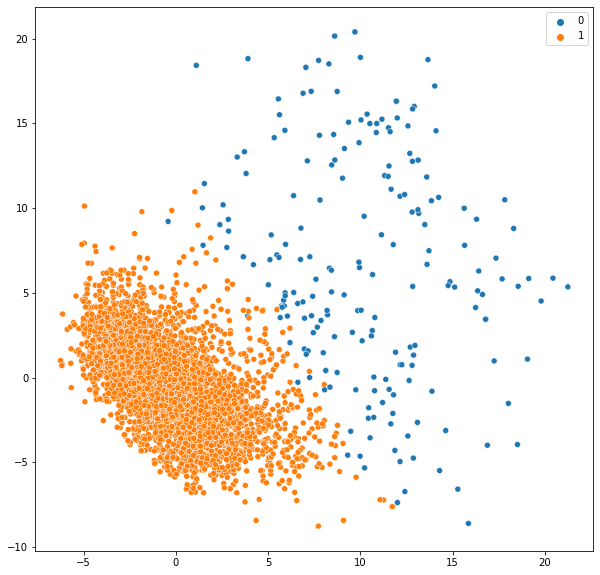

In [77]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=km.labels_);

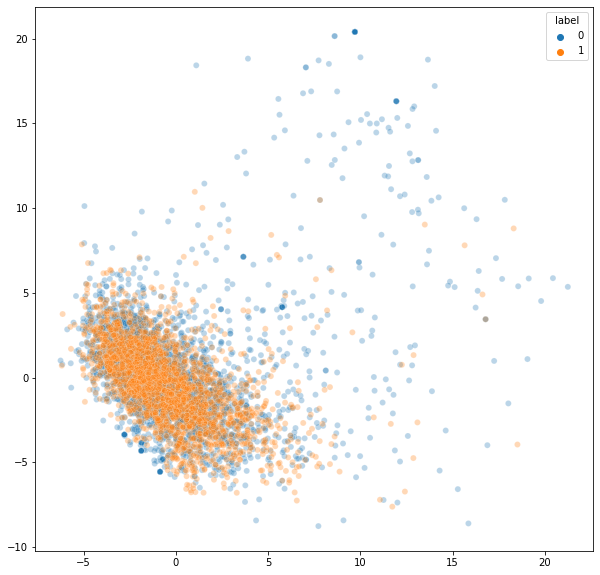

In [79]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3);

In [ ]:
np.mean(vecs, axis=1)

array([-0.00546921, -0.00127675], dtype=float32)